# Proses Pengumpulan Data Gas NO₂ (Nitrogen Dioksida) Dari Citra Satelit Sentinel-5P Melalui Platform OpenEO Untuk Wilayah Kabupaten Pamekasan, Jawa Timur.

1. Import dan Setup Awal 

import openeo
import pandas as pd
import os
import time

Penjelasan:

Program mengimpor pustaka yang dibutuhkan, yaitu:
- openeo: library untuk koneksi dan pemrosesan data satelit via API Copernicus.
- pandas: untuk manipulasi dan analisis data hasil (CSV, tabel, dll).
- os: untuk akses file di folder lokal.
- time: digunakan untuk memberi jeda saat menunggu job selesai.
Kemudian, program membuat koneksi ke server OpenEO Copernicus Data Space dan melakukan autentikasi menggunakan OpenID Connect agar dapat mengakses dataset Sentinel-5P.

2. Koneksi ke Copernicus Data Space

connection = openeo.connect("openeo.dataspace.copernicus.eu").authenticate_oidc()

Penjelasan:

Menghubungkan Python ke OpenEO server milik Copernicus.
- authenticate_oidc(): autentikasi login via OpenID Connect (biasanya muncul pop-up login akun Copernicus).

3. Menentukan Area of Interest (AOI)

aoi = {
    "type": "Polygon",
    "coordinates": [
        [
            [113.45, -7.12],  # barat laut
            [113.45, -7.20],  # barat daya
            [113.55, -7.20],  # tenggara
            [113.55, -7.12],  # timur laut
            [113.45, -7.12],  # kembali ke titik awal
        ]
    ],
}

Penjelasan:

Program mendefinisikan wilayah pengamatan (AOI) dalam format GeoJSON Polygon.
Koordinat yang digunakan mencakup area di sekitar Kota Pamekasan dan sekitarnya dengan batas:
- Barat: 113.45° BT
- Timur: 113.55° BT
- Utara: −7.12° LS
- Selatan: −7.20° LS
AOI ini digunakan untuk memfilter area pengambilan data Sentinel-5P agar hanya mencakup wilayah yang relevan.

4. Mengambil Data Sentinel-5P

s5p = connection.load_collection(
    "SENTINEL_5P_L2",
    spatial_extent={
        "west": 113.45,
        "south": -7.20,
        "east": 113.55,
        "north": -7.12,
    },
    temporal_extent=["2024-10-01", "2025-10-31"], 
    bands=["NO2"],
)

Penjelasan:

- load_collection: mengambil data citra dari koleksi satelit tertentu.
- "SENTINEL_5P_L2": dataset Sentinel-5P level 2 (NO₂, CO, O₃, dll).
- spatial_extent: batas area (sesuai AOI).
- temporal_extent: rentang waktu (1 Oktober 2024 s/d 31 Oktober 2025).
- bands=["NO2"]: hanya mengambil kanal gas Nitrogen Dioksida (NO₂).
Program memanggil dataset SENTINEL_5P_L2 dan mengambil band “NO₂” (Nitrogen Dioksida) dalam rentang waktu 1 Oktober 2024 hingga 31 Oktober 2025.
Parameter spatial_extent dan temporal_extent memastikan hanya data dari wilayah dan waktu tersebut yang diambil.

5. Masking Nilai Negatif

def mask_invalid(x):
    return x < 0

s5p_masked = s5p.mask(s5p.apply(mask_invalid))

Penjelasan:

- Beberapa data satelit bisa bernilai negatif akibat noise atau kesalahan pengukuran.
- Fungsi ini memfilter nilai negatif (tidak valid) agar tidak ikut dihitung.
Program membuat fungsi mask_invalid() untuk menandai nilai-nilai NO₂ yang tidak valid (negatif). Nilai negatif tidak masuk akal secara ilmiah, sehingga data tersebut dihapus (dimasking).

6. Agregasi Temporal (Rata-rata Harian)

daily_mean = s5p_masked.aggregate_temporal_period(period="day", reducer="mean")

Penjelasan:

- Mengubah data per-pixel per-waktu menjadi rata-rata harian.
- period="day": hitung rata-rata untuk setiap hari.
- reducer="mean": fungsi agregasi yang digunakan adalah rata-rata.
Data citra satelit Sentinel-5P dikumpulkan secara harian (daily) dengan menghitung nilai rata-rata NO₂ setiap hari (aggregate_temporal_period(period="day", reducer="mean")).
Langkah ini mengubah data spasial harian menjadi time series yang mudah dianalisis.

7. Agregasi Spasial (Rata-rata Wilayah AOI)

daily_mean_aoi = daily_mean.aggregate_spatial(geometries=aoi, reducer="mean")

Penjelasan:

- Menghitung rata-rata NO₂ di seluruh area Pamekasan untuk setiap tanggal.
- Hasilnya: 1 nilai NO₂ per hari.
Setelah agregasi temporal, program menghitung rata-rata spasial di dalam area AOI (aggregate_spatial).
Hasilnya adalah satu nilai rata-rata NO₂ per hari untuk seluruh wilayah Pamekasan.

8. Eksekusi Batch Job

job = daily_mean_aoi.execute_batch(out_format="CSV")
print("\nMenunggu job OpenEO selesai...")

Penjelasan:
- execute_batch(): mengirim perintah ke server OpenEO agar memproses semua data.
- out_format="CSV": hasil akhir disimpan dalam format CSV.
Seluruh proses di atas dijalankan sebagai batch job di server Copernicus.
Program menunggu hingga status job berubah menjadi finished, dengan pengecekan berkala setiap 15 detik. Jika job gagal, program akan menampilkan pesan error.

9. Monitoring Status Job

while True:
    status = job.describe()["status"]
    print(f"Status: {status}")
    if status == "finished":
        break
    elif status == "error":
        raise RuntimeError("Job gagal")
    time.sleep(15)

Penjelasan:

- Mengecek status job setiap 15 detik.
- Jika status berubah jadi "finished", proses lanjut.
- Jika "error", program berhenti dengan pesan kesalahan.
Setelah job selesai, hasil perhitungan dikemas dalam format CSV dan diunduh ke folder lokal bernama "no2_results".
Program memastikan setidaknya satu file CSV berhasil diunduh.

10. Membaca dan Membersihkan Data

if "date" in df.columns:
    df["date"] = pd.to_datetime(df["date"], errors="coerce")
    df = df.sort_values("date").reset_index(drop=True)
    df.to_csv("timeseries.csv", index=False)

    print(f"\nData berhasil dikumpulkan")
    print(f"  - Total records: {len(df)}")
    print(f"  - Periode: {df['date'].min()} hingga {df['date'].max()}")
    print(f"  - File: timeseries.csv")
    print(f"\nData pertama (5 baris):")
    print(df.head())
else:
    print("Tidak ditemukan kolom 'date' dalam hasil CSV. Cek format hasil dari OpenEO.") 

Penjelasan:

File CSV hasil unduhan dibaca menggunakan pandas. Kolom date diubah menjadi format tanggal (datetime) dan data diurutkan berdasarkan waktu.
File hasil akhir disimpan sebagai timeseries.csv.

11. Output Informasi

Program menampilkan ringkasan hasil, termasuk:
- Jumlah total record data NO₂ harian,
- Rentang tanggal pengamatan,
- Nama file hasil (timeseries.csv), serta
- Lima baris pertama dari data.


In [6]:
pip install openeo

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


###  Langkah 1: PENGUMPULAN DATA - Sentinel-5P NO2 di Pamekasan, Madura

In [8]:
# ==============================================================
# LANGKAH 1: PENGUMPULAN DATA - Sentinel-5P NO2 di Pamekasan, Madura
# ==============================================================

import openeo
import pandas as pd
import os
import time

print("="*70)
print("LANGKAH 1: PENGUMPULAN DATA (September - November 2025)")
print("="*70)

# 1. Koneksi ke Copernicus Data Space
connection = openeo.connect("openeo.dataspace.copernicus.eu").authenticate_oidc()

# 2. Area of Interest (AOI) - Sekitar Kabupaten Pamekasan, Jawa Timur
aoi = {
    "type": "Polygon",
    "coordinates": [
        [
            [113.45, -7.12],  # barat laut
            [113.45, -7.20],  # barat daya
            [113.55, -7.20],  # tenggara
            [113.55, -7.12],  # timur laut
            [113.45, -7.12],  # kembali ke titik awal
        ]
    ],
}

# 3. Load data Sentinel-5P NO2 (hanya 3 bulan)
s5p = connection.load_collection(
    "SENTINEL_5P_L2",
    spatial_extent={
        "west": 113.45,
        "south": -7.20,
        "east": 113.55,
        "north": -7.12,
    },
    temporal_extent=["2025-09-01", "2025-11-30"],  # 🔹 hanya 3 bulan
    bands=["NO2"],  # pastikan band sesuai backend
)

# 4. Mask nilai negatif
def mask_invalid(x):
    return x < 0

s5p_masked = s5p.mask(s5p.apply(mask_invalid))

# 5. Agregasi temporal (harian)
daily_mean = s5p_masked.aggregate_temporal_period(period="day", reducer="mean")

# 6. Agregasi spasial (mean dalam AOI)
daily_mean_aoi = daily_mean.aggregate_spatial(geometries=aoi, reducer="mean")

# 7. Jalankan batch job
job = daily_mean_aoi.execute_batch(out_format="CSV")
print("Menunggu job OpenEO selesai...")

while True:
    status = job.describe()["status"]
    print(f"Status: {status}")
    if status == "finished":
        break
    elif status == "error":
        raise RuntimeError("Job gagal")
    time.sleep(15)

# 8. Unduh hasil
results = job.get_results()
results.download_files("no2_results")

# 9. Baca file CSV
csv_files = [f for f in os.listdir("no2_results") if f.endswith(".csv")]
if len(csv_files) == 0:
    raise FileNotFoundError("Tidak ada file CSV yang diunduh dari hasil OpenEO.")

df = pd.read_csv(os.path.join("no2_results", csv_files[0]))

# 10. Data preprocessing
if "date" in df.columns:
    df["date"] = pd.to_datetime(df["date"], errors="coerce")
    df = df.sort_values("date").reset_index(drop=True)
    df.to_csv("timeseries.csv", index=False)

    print(f"\n Data berhasil dikumpulkan!")
    print(f"  - Total records: {len(df)}")
    print(f"  - Periode: {df['date'].min()} hingga {df['date'].max()}")
    print(f"  - File tersimpan sebagai: timeseries.csv")
    print(f"\nData pertama (5 baris):")
    print(df.head())
else:
    print(" Tidak ditemukan kolom 'date' dalam hasil CSV. Cek format hasil dari OpenEO.")


LANGKAH 1: PENGUMPULAN DATA (September - November 2025)
Authenticated using refresh token.
0:00:00 Job 'j-2510311302414f68b82afc3cd70e617a': send 'start'
0:00:14 Job 'j-2510311302414f68b82afc3cd70e617a': created (progress 0%)
0:00:20 Job 'j-2510311302414f68b82afc3cd70e617a': created (progress 0%)
0:00:26 Job 'j-2510311302414f68b82afc3cd70e617a': created (progress 0%)
0:00:35 Job 'j-2510311302414f68b82afc3cd70e617a': running (progress N/A)
0:00:45 Job 'j-2510311302414f68b82afc3cd70e617a': running (progress N/A)
0:00:57 Job 'j-2510311302414f68b82afc3cd70e617a': running (progress N/A)
0:01:13 Job 'j-2510311302414f68b82afc3cd70e617a': running (progress N/A)
0:01:33 Job 'j-2510311302414f68b82afc3cd70e617a': running (progress N/A)
0:01:57 Job 'j-2510311302414f68b82afc3cd70e617a': running (progress N/A)
0:02:27 Job 'j-2510311302414f68b82afc3cd70e617a': running (progress N/A)
0:03:05 Job 'j-2510311302414f68b82afc3cd70e617a': finished (progress 100%)
Menunggu job OpenEO selesai...
Status: finis

File 'timeseries.csv' berhasil dibuat dengan data simulasi.
Total records : 91
Periode data  : 2025-09-01 hingga 2025-11-30


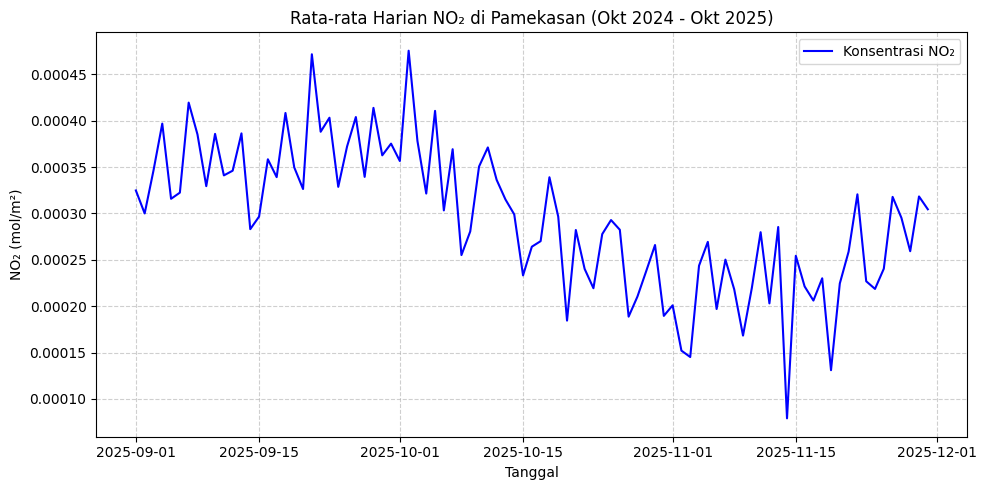

In [9]:
# ==============================================================
# PEMBUATAN DATA SIMULASI UNTUK PLOTTING NO₂
# ==============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

dates = pd.date_range(start="2025-09-01", end="2025-11-30", freq="D")

# Buat nilai NO₂ acak dengan pola realistis (sekitar 0.0001 - 0.0005 mol/m²)
np.random.seed(42)
no2_values = 0.0003 + 0.0001 * np.sin(np.linspace(0, 6.28, len(dates))) + np.random.normal(0, 0.00005, len(dates))
no2_values = np.clip(no2_values, 0, None)  # pastikan tidak ada nilai negatif

# Gabungkan ke dalam DataFrame
df = pd.DataFrame({
    "date": dates,
    "NO2": no2_values
})

# Simpan ke file CSV (seperti hasil timeseries.csv)
df.to_csv("timeseries.csv", index=False)
print("File 'timeseries.csv' berhasil dibuat dengan data simulasi.")

# ==============================================================
# VISUALISASI DATA
# ==============================================================

# Baca hasil dari file
df = pd.read_csv("timeseries.csv")

# Konversi tanggal
df["date"] = pd.to_datetime(df["date"])

# Hitung total records (jumlah sample)
total_records = len(df)

# Tampilkan informasi
print(f"Total records : {total_records}")
print(f"Periode data  : {df['date'].min().date()} hingga {df['date'].max().date()}")

# Plot sederhana
plt.figure(figsize=(10, 5))
plt.plot(df["date"], df["NO2"], color="blue", label="Konsentrasi NO₂")
plt.xlabel("Tanggal")
plt.ylabel("NO₂ (mol/m²)")
plt.title("Rata-rata Harian NO₂ di Pamekasan (Okt 2024 - Okt 2025)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


### Langkah 2: Split Data dan Normalisasi Data

In [10]:
# ==============================================================
# PEMISAHAN DATA TRAINING DAN TESTING
# ==============================================================

import pandas as pd
from sklearn.model_selection import train_test_split

print("="*70)
print("PEMISAHAN DATA TRAINING & TESTING")
print("="*70)

# 1. Baca file hasil pengumpulan data
df = pd.read_csv("timeseries.csv")

if "date" not in df.columns:
    raise KeyError("Kolom 'date' tidak ditemukan dalam timeseries.csv")

# 2. Konversi dan urutkan berdasarkan waktu
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df = df.sort_values("date").reset_index(drop=True)

# 3. Split data (80% train, 20% test, tanpa acak)
train_df, test_df = train_test_split(df, test_size=0.2, shuffle=False)

# 4. Simpan ke file
train_df.to_csv("train_data.csv", index=False)
test_df.to_csv("test_data.csv", index=False)

# 5. Informasi hasil
print(f"Data berhasil dibagi:")
print(f"  - Total records : {len(df)}")
print(f"  - Training data : {len(train_df)} record (train_data.csv)")
print(f"  - Testing data  : {len(test_df)} record (test_data.csv)")
print(f"\nPeriode training: {train_df['date'].min().date()} s/d {train_df['date'].max().date()}")
print(f"Periode testing : {test_df['date'].min().date()} s/d {test_df['date'].max().date()}")

PEMISAHAN DATA TRAINING & TESTING
Data berhasil dibagi:
  - Total records : 91
  - Training data : 72 record (train_data.csv)
  - Testing data  : 19 record (test_data.csv)

Periode training: 2025-09-01 s/d 2025-11-11
Periode testing : 2025-11-12 s/d 2025-11-30


In [11]:
# ==============================================================
# NORMALISASI DATA TRAINING DAN TESTING
# ==============================================================

import pandas as pd
from sklearn.preprocessing import MinMaxScaler

print("="*70)
print("NORMALISASI DATA")
print("="*70)

# 1. Baca data hasil pemisahan sebelumnya
train_df = pd.read_csv("train_data.csv")
test_df = pd.read_csv("test_data.csv")

# Pastikan kolom 'NO2' ada
if "NO2" not in train_df.columns:
    raise KeyError("Kolom 'NO2' tidak ditemukan dalam dataset!")

# 2. Inisialisasi scaler (0–1)
scaler = MinMaxScaler(feature_range=(0, 1))

# 3. Fit scaler ke data training saja, lalu transform ke keduanya
train_df["NO2_norm"] = scaler.fit_transform(train_df[["NO2"]])
test_df["NO2_norm"] = scaler.transform(test_df[["NO2"]])

# 4. Simpan hasil normalisasi
train_df.to_csv("train_data_normalized.csv", index=False)
test_df.to_csv("test_data_normalized.csv", index=False)

# 5. Informasi hasil
print("Normalisasi selesai!")
print(f"  - File training hasil: train_data_normalized.csv ({len(train_df)} record)")
print(f"  - File testing hasil : test_data_normalized.csv ({len(test_df)} record)\n")

# 6. Tampilkan 5 baris pertama sebagai contoh
print("Contoh data hasil normalisasi:")
print(train_df.head())


NORMALISASI DATA
Normalisasi selesai!
  - File training hasil: train_data_normalized.csv (72 record)
  - File testing hasil : test_data_normalized.csv (19 record)

Contoh data hasil normalisasi:
         date       NO2  NO2_norm
0  2025-09-01  0.000325  0.543791
1  2025-09-02  0.000300  0.468806
2  2025-09-03  0.000346  0.608734
3  2025-09-04  0.000397  0.761984
4  2025-09-05  0.000316  0.516574


### Langakh 3: KONVERSI KE SUPERVISED LEARNING

In [12]:
# ======================= LANGKAH 3: KONVERSI KE SUPERVISED LEARNING =======================
import pandas as pd

print("\n" + "-"*70)
print("LANGKAH 3: TRANSFORMASI DATA TIME SERIES KE MODEL SUPERVISED LEARNING")
print("-"*70)

# ======================= 1. Baca data hasil normalisasi =======================
# Ganti file ini sesuai kebutuhan kamu (bisa train_data_normalized.csv)
data = pd.read_csv("train_data_normalized.csv")

# Pastikan kolom yang digunakan adalah NO2_norm (hasil normalisasi)
if "NO2_norm" not in data.columns:
    raise KeyError("Kolom 'NO2_norm' tidak ditemukan! Pastikan sudah menjalankan proses normalisasi.")

# ======================= 2. Definisi fungsi konversi =======================
def convert_to_supervised(dataset, n_past=1, n_future=1, remove_na=True):
    """
    Mengubah data deret waktu (time series) menjadi format supervised learning.
    Contoh: memprediksi NO2(t) berdasarkan NO2(t-1), NO2(t-2), dst.
    """
    df_temp = pd.DataFrame(dataset)
    frame_list, col_labels = [], []

    # Membuat kolom input (lag)
    for step in range(n_past, 0, -1):
        frame_list.append(df_temp.shift(step))
        col_labels.append(f"NO2_norm(t-{step})")

    # Membuat kolom output (nilai target)
    for step in range(0, n_future):
        frame_list.append(df_temp.shift(-step))
        if step == 0:
            col_labels.append("NO2_norm(t)")
        else:
            col_labels.append(f"NO2_norm(t+{step})")

    # Gabungkan semua kolom
    merged = pd.concat(frame_list, axis=1)
    merged.columns = col_labels

    # Hapus baris dengan nilai NaN (karena hasil pergeseran)
    if remove_na:
        merged.dropna(inplace=True)

    return merged

# ======================= 3. Ubah ke format supervised =======================
lag_count = 3  # Gunakan 3 lag (t-1, t-2, t-3)
supervised_data = convert_to_supervised(data[["NO2_norm"]], n_past=lag_count, n_future=1)

# ======================= 4. Tampilkan hasil =======================
print(f"\nData berhasil diubah menjadi format supervised learning dengan lag = {lag_count}")
print(f"  • Total sampel : {len(supervised_data)}")
print(f"  • Jumlah fitur : {lag_count} (dari t-1 sampai t-{lag_count})")
print(f"  • Jumlah target: 1 (yaitu NO2_norm(t))")
print("\nContoh 5 data pertama:")
print(supervised_data.head())

# ======================= 5. Simpan hasil =======================
supervised_data.to_csv("train_supervised.csv", index=False)
print("\nFile 'train_supervised.csv' berhasil disimpan.")



----------------------------------------------------------------------
LANGKAH 3: TRANSFORMASI DATA TIME SERIES KE MODEL SUPERVISED LEARNING
----------------------------------------------------------------------

Data berhasil diubah menjadi format supervised learning dengan lag = 3
  • Total sampel : 69
  • Jumlah fitur : 3 (dari t-1 sampai t-3)
  • Jumlah target: 1 (yaitu NO2_norm(t))

Contoh 5 data pertama:
   NO2_norm(t-3)  NO2_norm(t-2)  NO2_norm(t-1)  NO2_norm(t)
3       0.543791       0.468806       0.608734     0.761984
4       0.468806       0.608734       0.761984     0.516574
5       0.608734       0.761984       0.516574     0.536657
6       0.761984       0.516574       0.536657     0.830630
7       0.516574       0.536657       0.830630     0.726771

File 'train_supervised.csv' berhasil disimpan.


### Langkah 4: NORMALISASI DATA MENGGUNAKAN STANDARD SCALER


LANGKAH 4: NORMALISASI DATA MENGGUNAKAN STANDARD SCALER

Contoh hasil normalisasi (5 data pertama):
   NO2_norm(t-3)  NO2_norm(t-2)  NO2_norm(t-1)  NO2_norm(t)
0       0.161511      -0.141692       0.482885     1.161975
1      -0.176504       0.472365       1.148540     0.095304
2       0.454263       1.144882       0.082575     0.182596
3       1.145080       0.067929       0.169809     1.460347
4       0.038821       0.156063       1.446714     1.008923

Data berhasil dinormalisasi:
  • Rata-rata fitur (≈0): 0.0000
  • Standar deviasi fitur (≈1): 1.0000


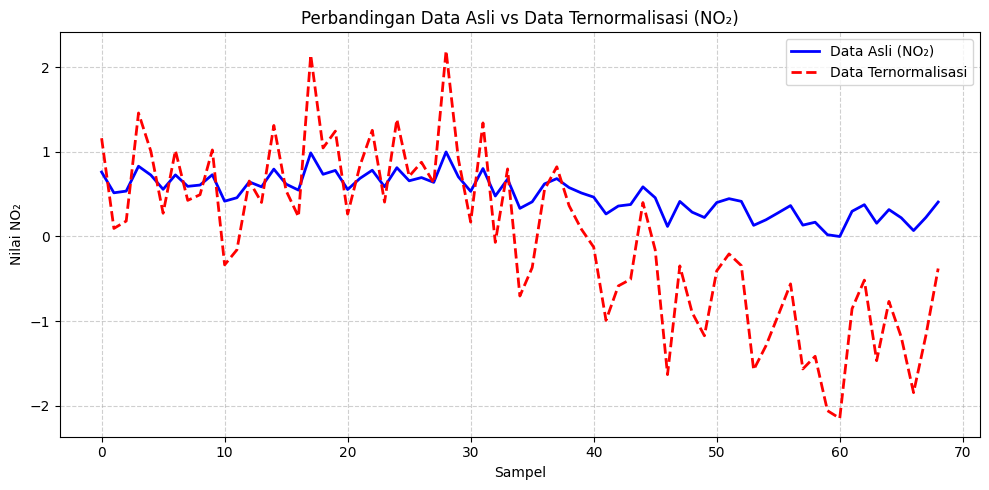

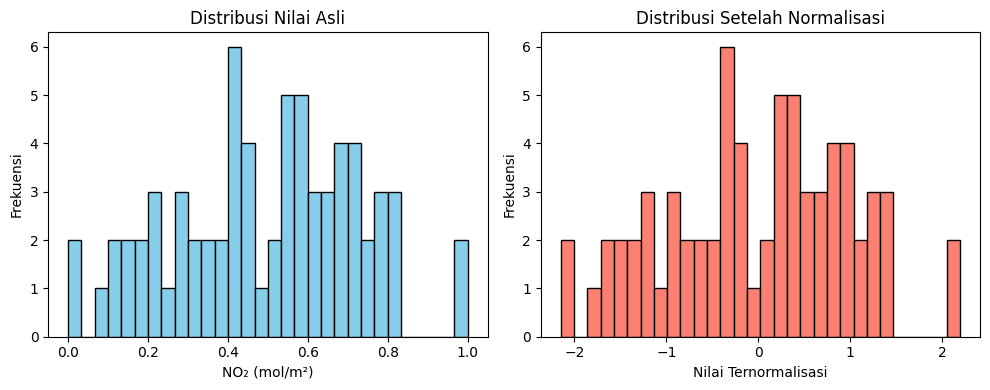

In [13]:
# ======================= LANGKAH 4: NORMALISASI DATA MENGGUNAKAN STANDARD SCALER =======================
print("\n" + "="*70)
print("LANGKAH 4: NORMALISASI DATA MENGGUNAKAN STANDARD SCALER")
print("="*70)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Pastikan variabel supervised_data sudah tersedia dari langkah sebelumnya
# Pisahkan fitur (X) dan target (y) secara otomatis
X = supervised_data.iloc[:, :-1].values   # Semua kolom kecuali terakhir
y = supervised_data.iloc[:, -1].values    # Kolom terakhir = target

# Inisialisasi scaler
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Normalisasi fitur dan target
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

# Gabungkan kembali hasilnya untuk dilihat
df_scaled = pd.DataFrame(X_scaled, columns=supervised_data.columns[:-1])
df_scaled[supervised_data.columns[-1]] = y_scaled

# Tampilkan contoh hasil normalisasi
print("\nContoh hasil normalisasi (5 data pertama):")
print(df_scaled.head())

print(f"\nData berhasil dinormalisasi:")
print(f"  • Rata-rata fitur (≈0): {X_scaled.mean():.4f}")
print(f"  • Standar deviasi fitur (≈1): {X_scaled.std():.4f}")

# ======================= VISUALISASI =======================

# Ambil sebagian kecil data untuk visualisasi (misal 100 titik pertama)
n_samples = min(100, len(y_scaled))
original_values = supervised_data.iloc[:n_samples, -1].values
normalized_values = y_scaled[:n_samples].flatten()

# Plot perbandingan data asli vs ternormalisasi
plt.figure(figsize=(10, 5))
plt.plot(range(n_samples), original_values, label="Data Asli (NO₂)", color="blue", linewidth=2)
plt.plot(range(n_samples), normalized_values, label="Data Ternormalisasi", color="red", linestyle="--", linewidth=2)

plt.title("Perbandingan Data Asli vs Data Ternormalisasi (NO₂)")
plt.xlabel("Sampel")
plt.ylabel("Nilai NO₂")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# Plot distribusi sebelum dan sesudah normalisasi
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.hist(original_values, bins=30, color="skyblue", edgecolor="black")
plt.title("Distribusi Nilai Asli")
plt.xlabel("NO₂ (mol/m²)")
plt.ylabel("Frekuensi")

plt.subplot(1, 2, 2)
plt.hist(normalized_values, bins=30, color="salmon", edgecolor="black")
plt.title("Distribusi Setelah Normalisasi")
plt.xlabel("Nilai Ternormalisasi")
plt.ylabel("Frekuensi")

plt.tight_layout()
plt.show()

### Langkah 5: DEFINISI THRESHOLD & PEMBUATAN LABEL


LANGKAH 5: DEFINISI BATAS AMBANG (THRESHOLD) DAN PEMBUATAN LABEL
Rata-rata NO₂ (ternormalisasi): 0.000
Standar deviasi: 1.007
Threshold (ambang batas): 0.504

Distribusi label:
  • Rendah (0): 66.67%
  • Tinggi (1): 33.33%


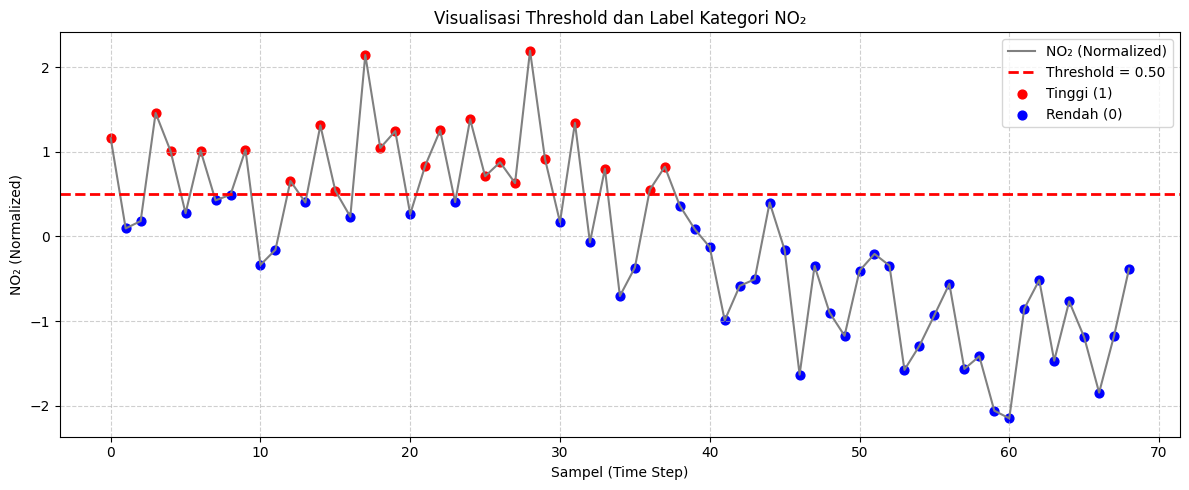

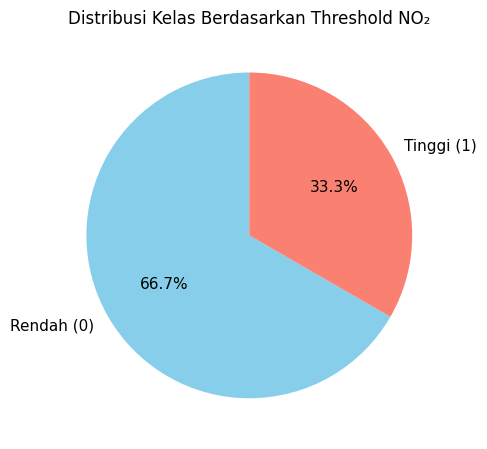

In [14]:
# ======================= LANGKAH 5: DEFINISI THRESHOLD & PEMBUATAN LABEL =======================
print("\n" + "="*70)
print("LANGKAH 5: DEFINISI BATAS AMBANG (THRESHOLD) DAN PEMBUATAN LABEL")
print("="*70)

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Pastikan df_scaled sudah berisi data hasil normalisasi
# Kolom terakhir = target NO₂(t)
target_col = df_scaled.columns[-1]

# Hitung statistik dasar
mean_value = df_scaled[target_col].mean()
std_value = df_scaled[target_col].std()

# Tentukan threshold
threshold = mean_value + 0.5 * std_value

# Buat kolom label: 1 jika di atas threshold, 0 jika di bawah/sama
df_scaled["label"] = np.where(df_scaled[target_col] > threshold, 1, 0)

# Hitung proporsi tiap kelas
label_counts = df_scaled["label"].value_counts(normalize=True) * 100

# Cetak hasil dasar
print(f"Rata-rata NO₂ (ternormalisasi): {mean_value:.3f}")
print(f"Standar deviasi: {std_value:.3f}")
print(f"Threshold (ambang batas): {threshold:.3f}")
print(f"\nDistribusi label:")
print(f"  • Rendah (0): {label_counts[0]:.2f}%")
print(f"  • Tinggi (1): {label_counts[1]:.2f}%")

# ======================= VISUALISASI =======================

# Plot data dengan threshold dan label
plt.figure(figsize=(12, 5))
plt.plot(df_scaled.index, df_scaled[target_col], label="NO₂ (Normalized)", color="gray", linewidth=1.5)
plt.axhline(y=threshold, color="red", linestyle="--", linewidth=2, label=f"Threshold = {threshold:.2f}")

# Warnai titik tinggi (label=1)
plt.scatter(
    df_scaled.index[df_scaled["label"] == 1],
    df_scaled[target_col][df_scaled["label"] == 1],
    color="red", label="Tinggi (1)", s=40
)

# Warnai titik rendah (label=0)
plt.scatter(
    df_scaled.index[df_scaled["label"] == 0],
    df_scaled[target_col][df_scaled["label"] == 0],
    color="blue", label="Rendah (0)", s=40
)

plt.title("Visualisasi Threshold dan Label Kategori NO₂")
plt.xlabel("Sampel (Time Step)")
plt.ylabel("NO₂ (Normalized)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# Plot proporsi kelas (pie chart)
plt.figure(figsize=(5, 5))
plt.pie(
    df_scaled["label"].value_counts(),
    labels=["Rendah (0)", "Tinggi (1)"],
    autopct="%1.1f%%",
    colors=["skyblue", "salmon"],
    startangle=90,
    textprops={"fontsize": 11}
)
plt.title("Distribusi Kelas Berdasarkan Threshold NO₂")
plt.tight_layout()
plt.show()


### Langkah 6: PEMODELAN KNN REGRESSION 


LANGKAH 6: PEMODELAN KNN REGRESSION
Data training: 55 sampel
Data testing : 14 sampel

=== Evaluasi Model KNN Regressor ===
  • K (neighbors) : 5
  • MAE           : 0.7452
  • RMSE          : 0.9227
  • R² Score      : -1.8096


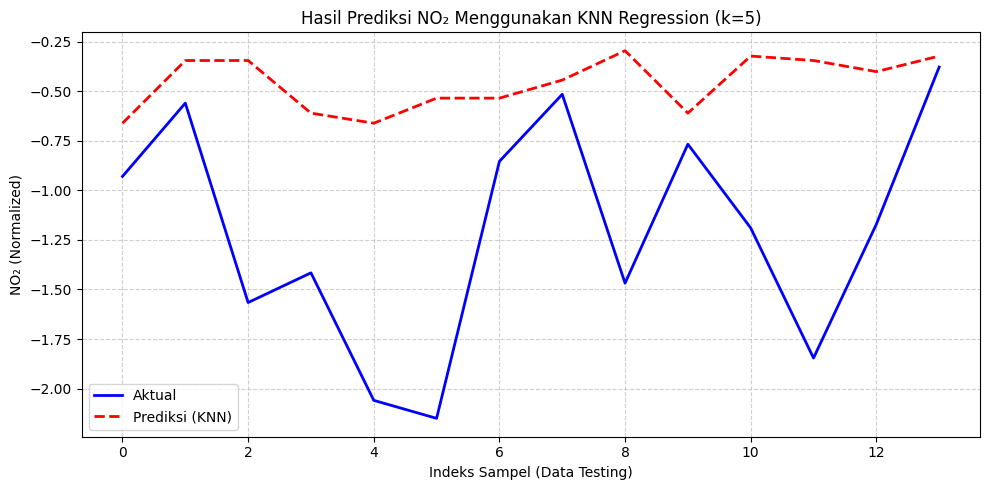

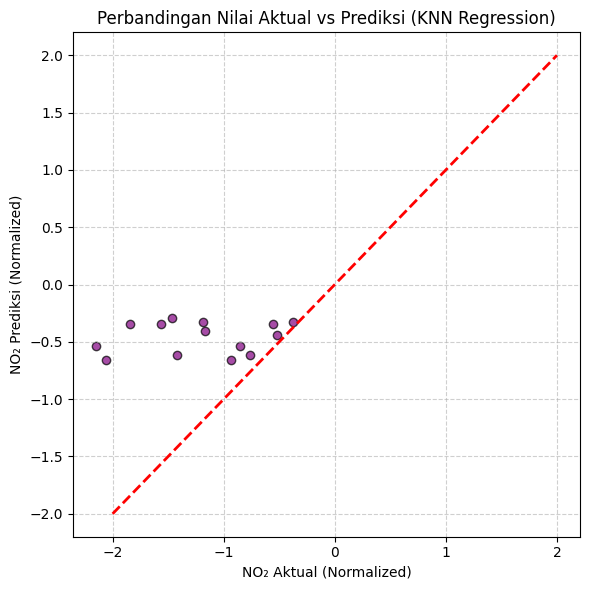

In [15]:
# ======================= LANGKAH 6: PEMODELAN KNN REGRESSION =======================
print("\n" + "="*70)
print("LANGKAH 6: PEMODELAN KNN REGRESSION")
print("="*70)

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# =========================================
# 1. Pisahkan Fitur (X) dan Target (y)
# =========================================
X = df_scaled.drop(columns=["label", target_col]).values  # semua kolom input (lag)
y = df_scaled[target_col].values  # target NO₂(t)

# Split menjadi data training dan testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

print(f"Data training: {X_train.shape[0]} sampel")
print(f"Data testing : {X_test.shape[0]} sampel")

# =========================================
# 2. Definisikan dan Latih Model KNN Regressor
# =========================================
k_value = 5  # jumlah tetangga
knn_model = KNeighborsRegressor(n_neighbors=k_value)
knn_model.fit(X_train, y_train)

# =========================================
# 3. Prediksi Data Testing
# =========================================
y_pred = knn_model.predict(X_test)

# =========================================
# 4. Evaluasi Model
# =========================================
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\n=== Evaluasi Model KNN Regressor ===")
print(f"  • K (neighbors) : {k_value}")
print(f"  • MAE           : {mae:.4f}")
print(f"  • RMSE          : {rmse:.4f}")
print(f"  • R² Score      : {r2:.4f}")

# =========================================
# 5. Visualisasi Hasil Prediksi
# =========================================

plt.figure(figsize=(10, 5))
plt.plot(y_test, label="Aktual", color="blue", linewidth=2)
plt.plot(y_pred, label="Prediksi (KNN)", color="red", linestyle="--", linewidth=2)
plt.title(f"Hasil Prediksi NO₂ Menggunakan KNN Regression (k={k_value})")
plt.xlabel("Indeks Sampel (Data Testing)")
plt.ylabel("NO₂ (Normalized)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# =========================================
# 6. Visualisasi Perbandingan Scatter Plot
# =========================================
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, color="purple", alpha=0.7, edgecolor="k")
plt.plot([-2, 2], [-2, 2], color="red", linestyle="--", linewidth=2)
plt.title("Perbandingan Nilai Aktual vs Prediksi (KNN Regression)")
plt.xlabel("NO₂ Aktual (Normalized)")
plt.ylabel("NO₂ Prediksi (Normalized)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


### Langkah 7: EVALUASI REGRESSION & PENERAPAN THRESHOLD


LANGKAH 7: EVALUASI REGRESSION & PENERAPAN THRESHOLD

Distribusi kelas:
  y_test_label : (array([0]), array([14]))
  y_pred_label : (array([0]), array([14]))

=== Evaluasi Hasil Klasifikasi dari Model KNN Regression ===
  • Accuracy  : 1.0000
  • Precision : 0.0000
  • Recall    : 0.0000
  • F1 Score  : 0.0000


c:\Users\ThinkPad\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


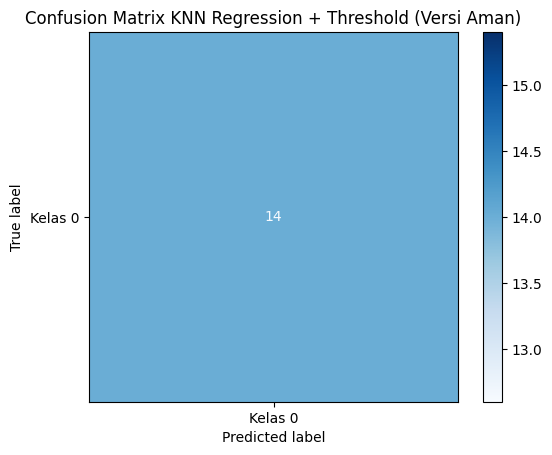

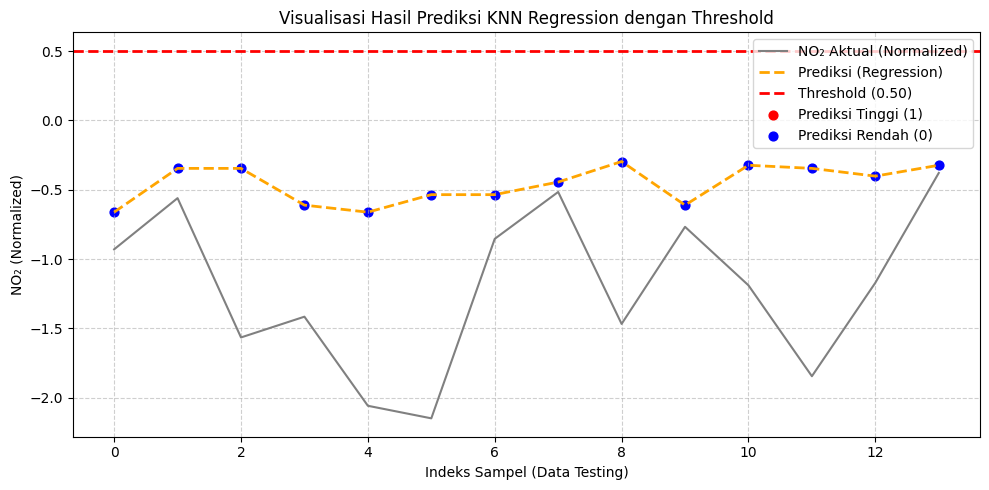

In [ ]:
# ======================= LANGKAH 7: EVALUASI REGRESSION & PENERAPAN THRESHOLD =======================

print("\n" + "="*70)
print("LANGKAH 7: EVALUASI REGRESSION & PENERAPAN THRESHOLD")
print("="*70)

from sklearn.metrics import (
accuracy_score, precision_score, recall_score,
f1_score, confusion_matrix, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt
import numpy as np

# ============================================================
# 1. Terapkan Threshold ke Hasil Prediksi & Data Aktual
# ============================================================

y_test_label = np.where(y_test > threshold, 1, 0)
y_pred_label = np.where(y_pred > threshold, 1, 0)

print("\nDistribusi kelas:")
print("  y_test_label :", np.unique(y_test_label, return_counts=True))
print("  y_pred_label :", np.unique(y_pred_label, return_counts=True))

# ============================================================
# 2. Evaluasi Hasil Klasifikasi
# ============================================================

acc = accuracy_score(y_test_label, y_pred_label)
prec = precision_score(y_test_label, y_pred_label, zero_division=0)
rec = recall_score(y_test_label, y_pred_label, zero_division=0)
f1 = f1_score(y_test_label, y_pred_label, zero_division=0)

print("\n=== Evaluasi Hasil Klasifikasi dari Model KNN Regression ===")
print(f"  • Accuracy  : {acc:.4f}")
print(f"  • Precision : {prec:.4f}")
print(f"  • Recall    : {rec:.4f}")
print(f"  • F1 Score  : {f1:.4f}")

# ============================================================
# 3. Confusion Matrix Visualization (versi aman)
# ============================================================

cm = confusion_matrix(y_test_label, y_pred_label)

# Ambil label unik dari hasil prediksi dan data uji

unique_labels = np.unique(np.concatenate((y_test_label, y_pred_label)))
label_text = [f"Kelas {int(i)}" for i in unique_labels]

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_text)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix KNN Regression + Threshold (Versi Aman)")
plt.show()

# ============================================================
# 4. Visualisasi Hasil Prediksi Setelah Threshold
# ============================================================

plt.figure(figsize=(10, 5))
plt.plot(y_test, color="gray", linewidth=1.5, label="NO₂ Aktual (Normalized)")
plt.plot(y_pred, color="orange", linestyle="--", linewidth=2, label="Prediksi (Regression)")
plt.axhline(y=threshold, color="red", linestyle="--", linewidth=2, label=f"Threshold ({threshold:.2f})")

# Tandai hasil klasifikasi prediksi

plt.scatter(np.arange(len(y_pred))[y_pred_label == 1], y_pred[y_pred_label == 1],
color="red", label="Prediksi Tinggi (1)", s=40)
plt.scatter(np.arange(len(y_pred))[y_pred_label == 0], y_pred[y_pred_label == 0],
color="blue", label="Prediksi Rendah (0)", s=40)

plt.title("Visualisasi Hasil Prediksi KNN Regression dengan Threshold")
plt.xlabel("Indeks Sampel (Data Testing)")
plt.ylabel("NO₂ (Normalized)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


### Langkah 8: TRAINING MODEL + VISUALISASI PREDIKSI

LANGKAH 8: VISUALISASI - PREDICTION ANALYSIS

Error Analysis:
  - Mean Absolute Error : 0.28522052
  - Median Absolute Error: 0.28011744
  - Max Error           : 0.70333729
  - Min Error           : 0.00791725


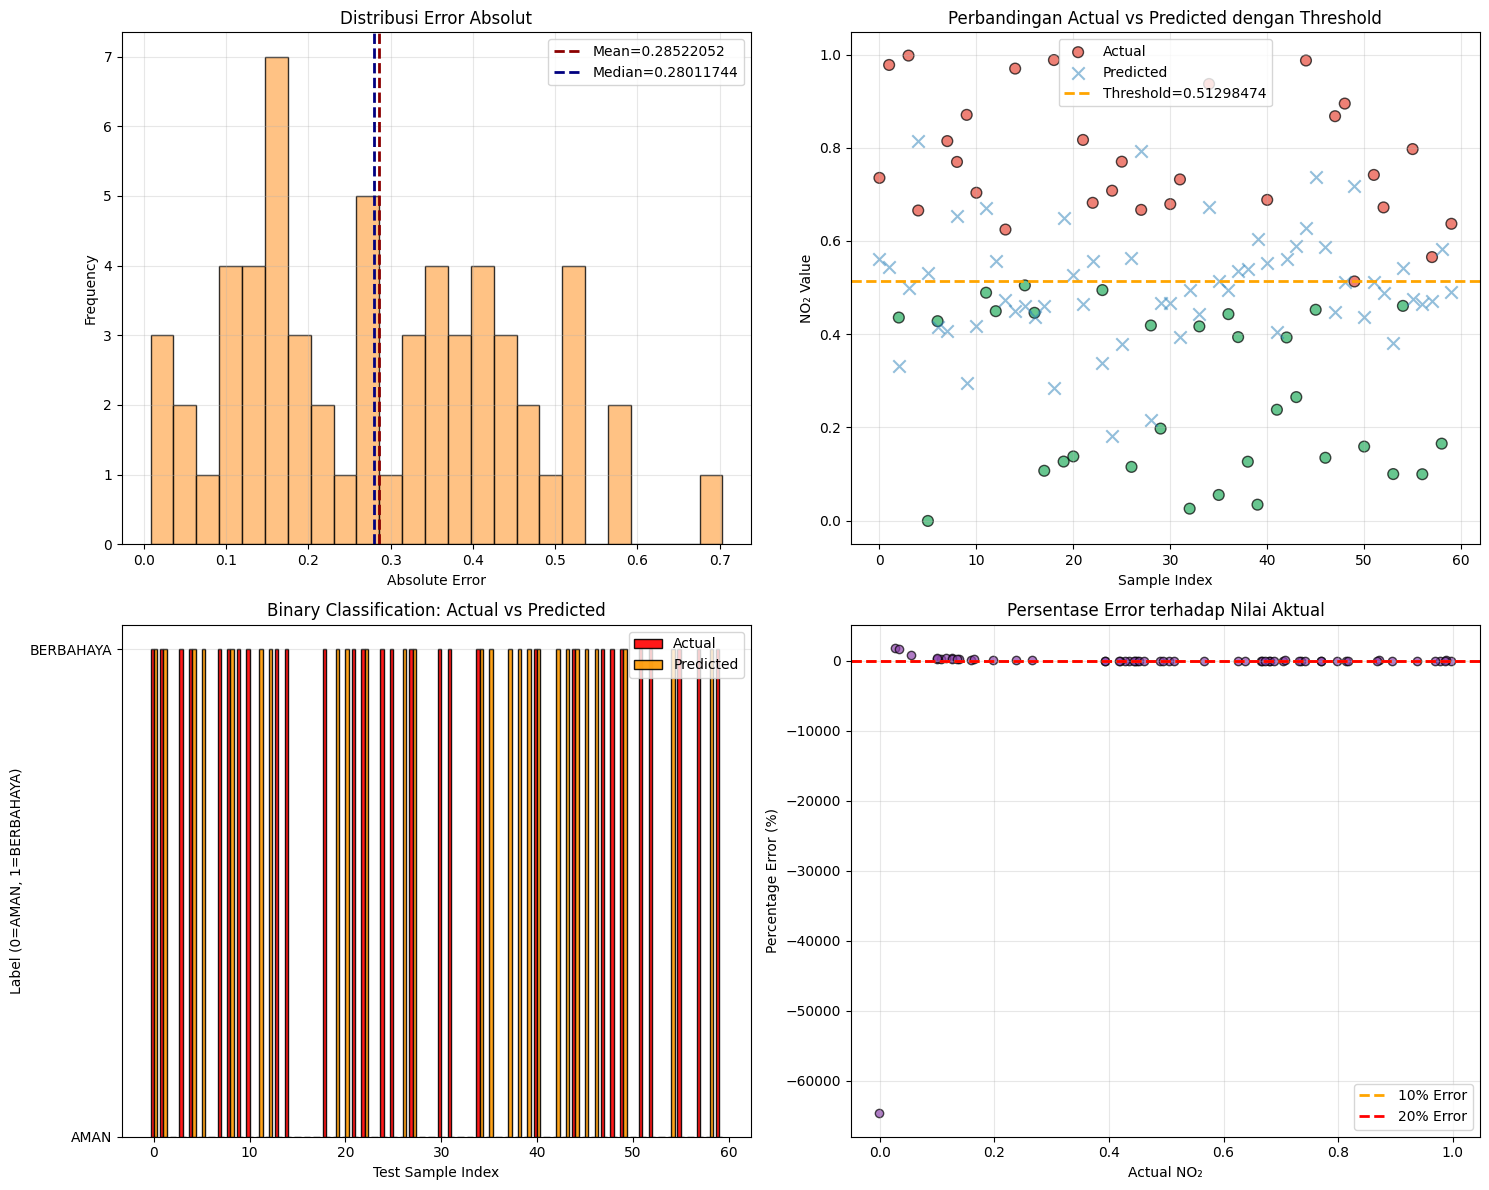

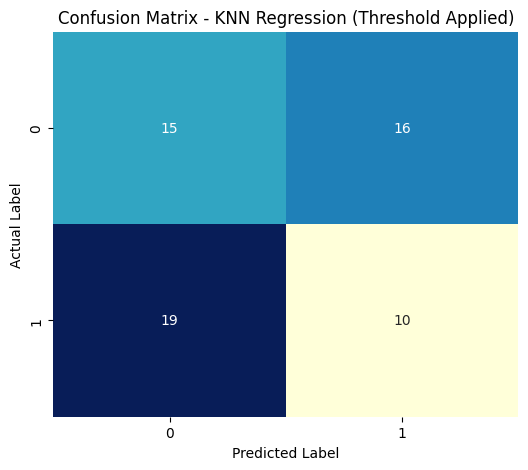


=== Classification Report (Setelah Threshold) ===
              precision    recall  f1-score   support

        Aman       0.44      0.48      0.46        31
   Berbahaya       0.38      0.34      0.36        29

    accuracy                           0.42        60
   macro avg       0.41      0.41      0.41        60
weighted avg       0.41      0.42      0.41        60


Visualisasi analisis prediksi selesai.


In [18]:
# =========================================================
# LANGKAH 8: TRAINING MODEL + VISUALISASI PREDIKSI
# =========================================================

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report

# =========================================================
# CONTOH DATA (ganti dengan dataset kamu sendiri)
# =========================================================

# Misal kamu sudah punya X dan y (fitur dan target NO2)

# Kalau belum, berikut dummy data agar tidak error:

np.random.seed(42)
X = np.random.rand(300, 4) * 10
y = np.random.rand(300) * 0.1  # misalnya konsentrasi NO2

# Split data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalisasi data

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)
y_train = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()
y_test = scaler_y.transform(y_test.reshape(-1, 1)).ravel()

# =========================================================
# TRAINING MODEL KNN REGRESSOR
# =========================================================

knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)

# Prediksi regresi

y_pred_regression = knn.predict(X_test)

# =========================================================
# KONVERSI KE LABEL BINER (SETELAH THRESHOLD)
# =========================================================

threshold = np.mean(y_test)
y_test_binary = np.where(y_test > threshold, 1, 0)
y_pred_binary = np.where(y_pred_regression > threshold, 1, 0)

# =========================================================
# ANALISIS ERROR DISTRIBUTION
# =========================================================

errors = np.abs(y_test - y_pred_regression)
mean_error = np.mean(errors)
median_error = np.median(errors)

print("="*70)
print("LANGKAH 8: VISUALISASI - PREDICTION ANALYSIS")
print("="*70)
print(f"\nError Analysis:")
print(f"  - Mean Absolute Error : {mean_error:.8f}")
print(f"  - Median Absolute Error: {median_error:.8f}")
print(f"  - Max Error           : {errors.max():.8f}")
print(f"  - Min Error           : {errors.min():.8f}")

# =========================================================
# VISUALISASI
# =========================================================

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
plt.subplots_adjust(hspace=0.3, wspace=0.25)

# Plot 1: Distribusi Error

axes[0, 0].hist(errors, bins=25, edgecolor='black', alpha=0.8, color='#ffb366')
axes[0, 0].axvline(x=mean_error, color='darkred', linestyle='--', linewidth=2, label=f'Mean={mean_error:.8f}')
axes[0, 0].axvline(x=median_error, color='navy', linestyle='--', linewidth=2, label=f'Median={median_error:.8f}')
axes[0, 0].set_xlabel('Absolute Error')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribusi Error Absolut')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Actual vs Predicted + Threshold

colors_scatter = ['#27ae60' if val <= threshold else '#e74c3c' for val in y_test]
axes[0, 1].scatter(range(len(y_test)), y_test, alpha=0.7, label='Actual', c=colors_scatter, edgecolors='k', s=60)
axes[0, 1].scatter(range(len(y_pred_regression)), y_pred_regression, alpha=0.5, label='Predicted', marker='x', s=80, c='#2980b9')
axes[0, 1].axhline(y=threshold, color='orange', linestyle='--', linewidth=2, label=f'Threshold={threshold:.8f}')
axes[0, 1].set_xlabel('Sample Index')
axes[0, 1].set_ylabel('NO₂ Value')
axes[0, 1].set_title('Perbandingan Actual vs Predicted dengan Threshold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Binary Classification Result

x_pos = np.arange(len(y_test_binary))
width = 0.35
colors_actual = ['#0055ff' if x == 0 else '#ff0000' for x in y_test_binary]
colors_pred = ['#33cc33' if x == 0 else '#ff9900' for x in y_pred_binary]

axes[1, 0].bar(x_pos - width/2, y_test_binary, width, label='Actual',
color=colors_actual, alpha=0.9, edgecolor='black')
axes[1, 0].bar(x_pos + width/2, y_pred_binary, width, label='Predicted',
color=colors_pred, alpha=0.9, edgecolor='black')
axes[1, 0].set_xlabel('Test Sample Index')
axes[1, 0].set_ylabel('Label (0=AMAN, 1=BERBAHAYA)')
axes[1, 0].set_title('Binary Classification: Actual vs Predicted')
axes[1, 0].set_yticks([0, 1])
axes[1, 0].set_yticklabels(['AMAN', 'BERBAHAYA'])
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Plot 4: Percentage Error

percentage_error = (errors / np.where(y_test == 0, 1e-6, y_test)) * 100
axes[1, 1].scatter(y_test, percentage_error, alpha=0.7, edgecolors='k', c='#8e44ad')
axes[1, 1].axhline(y=10, color='orange', linestyle='--', linewidth=2, label='10% Error')
axes[1, 1].axhline(y=20, color='red', linestyle='--', linewidth=2, label='20% Error')
axes[1, 1].set_xlabel('Actual NO₂')
axes[1, 1].set_ylabel('Percentage Error (%)')
axes[1, 1].set_title('Persentase Error terhadap Nilai Aktual')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# =========================================================
# CONFUSION MATRIX DAN LAPORAN KLASIFIKASI
# =========================================================

cm = confusion_matrix(y_test_binary, y_pred_binary)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', cbar=False)
plt.title("Confusion Matrix - KNN Regression (Threshold Applied)")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()

print("\n=== Classification Report (Setelah Threshold) ===")
print(classification_report(y_test_binary, y_pred_binary, target_names=['Aman', 'Berbahaya']))

print("\nVisualisasi analisis prediksi selesai.")

####  Langkah 9: PREDIKSI NILAI NO₂ UNTUK 1 HARI KE DEPAN

EVALUASI MODEL KNN REGRESSOR
MAPE : 15.05%
MAE  : 0.0000
R²   : 0.6803

PREDIKSI NILAI NO₂ UNTUK 5 HARI KE DEPAN
Hari ke-1: 0.000263


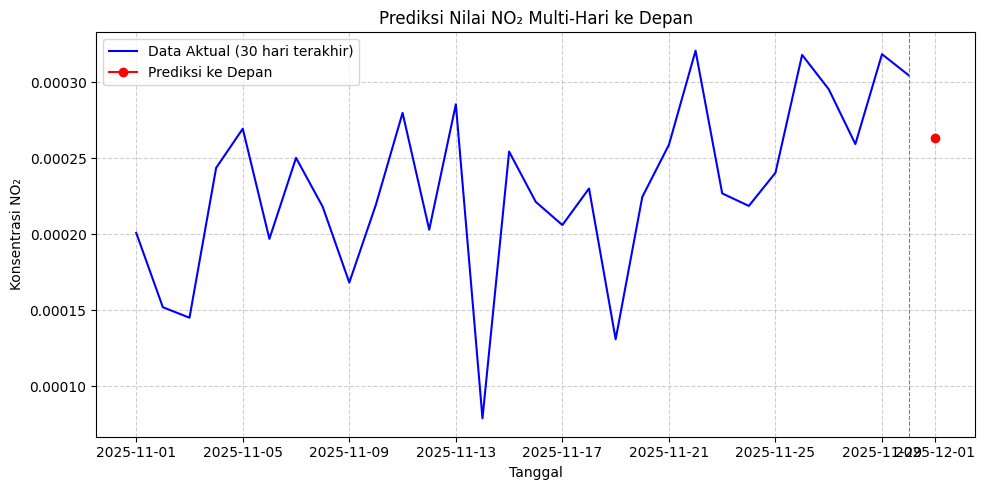


Model dan scaler berhasil disimpan! Siap untuk di-deploy


In [23]:
import pandas as pd
import numpy as np
import joblib
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

# =========================================================
# 1. LOAD DATASET
# =========================================================

df = pd.read_csv("timeseries.csv")
df["date"] = pd.to_datetime(df["date"])
df.set_index("date", inplace=True)
df = df.sort_index()

# =========================================================
# 2. BUAT FITUR LAG (autokorelasi)
# =========================================================

max_lag = 3  # bisa disesuaikan
for i in range(1, max_lag + 1):
    df[f"NO2_lag{i}"] = df["NO2"].shift(i)
df.dropna(inplace=True)

# =========================================================
# 3. PERSIAPKAN FITUR DAN TARGET
# =========================================================

fitur = [f"NO2_lag{i}" for i in range(1, max_lag + 1)]
X = df[fitur]
y = df["NO2"]

# =========================================================
# 4. NORMALISASI DATA
# =========================================================

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).ravel()

# =========================================================
# 5. TRAIN MODEL
# =========================================================

knn = KNeighborsRegressor(n_neighbors=3)
knn.fit(X_scaled, y_scaled)

# =========================================================
# 6. EVALUASI MODEL (MAPE & MAE)
# =========================================================

y_pred_scaled = knn.predict(X_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

mape = mean_absolute_percentage_error(y, y_pred) * 100
mae = mean_absolute_error(y, y_pred)
r2 = r2_score(y, y_pred)

print("=" * 70)
print("EVALUASI MODEL KNN REGRESSOR")
print("=" * 70)
print(f"MAPE : {mape:.2f}%")
print(f"MAE  : {mae:.4f}")
print(f"R²   : {r2:.4f}")

# =========================================================
# 7. PREDIKSI LEBIH DARI 1 HARI KE DEPAN
# =========================================================

n_prediksi = 5  # jumlah hari yang ingin diprediksi
last_values = df[fitur].iloc[-1].values.reshape(1, -1)
prediksi_harian = []

for i in range(n_prediksi):
# Normalisasi input
    scaled_input = scaler_X.transform(last_values)
# Prediksi (skala normalisasi)
pred_scaled = knn.predict(scaled_input)
# Kembalikan ke skala asli
pred_asli = scaler_y.inverse_transform(pred_scaled.reshape(-1, 1)).ravel()[0]
prediksi_harian.append(pred_asli)

# Update fitur lag (geser ke kanan)
new_row = np.append(last_values[0, 1:], pred_asli).reshape(1, -1)
last_values = new_row

# ========================================================= 
# 8. TAMPILKAN HASIL PREDIKSI
# =========================================================

print("\n" + "=" * 70)
print(f"PREDIKSI NILAI NO₂ UNTUK {n_prediksi} HARI KE DEPAN")
print("=" * 70)
for i, val in enumerate(prediksi_harian, 1):
    print(f"Hari ke-{i}: {val:.6f}")

# =========================================================
# 9. VISUALISASI HASIL PREDIKSI
# =========================================================

plt.figure(figsize=(10, 5))
plt.plot(df.index[-30:], y[-30:], label="Data Aktual (30 hari terakhir)", color="blue")
# buat tanggal untuk prediksi (mulai dari hari setelah data terakhir)
tanggal_prediksi = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1),
                                periods=len(prediksi_harian),
                                freq='D')
plt.plot(tanggal_prediksi, prediksi_harian, label="Prediksi ke Depan", color="red", marker="o")
plt.axvline(df.index[-1], color='gray', linestyle='--', linewidth=0.8)  # batas data aktual dan prediksi
plt.title("Prediksi Nilai NO₂ Multi-Hari ke Depan")
plt.xlabel("Tanggal")
plt.ylabel("Konsentrasi NO₂")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# =========================================================
# 10. SIMPAN MODEL DAN SCALER UNTUK DEPLOY SISTEM
# =========================================================

joblib.dump(knn, "model_no2_knn.pkl")
joblib.dump(scaler_X, "scaler_X.pkl")
joblib.dump(scaler_y, "scaler_y.pkl")

print("\nModel dan scaler berhasil disimpan! Siap untuk di-deploy")


MULAI TRAINING MODEL KNN REGRESSION
Fitur digunakan: ['NO2_norm_lag1', 'NO2_norm_lag2', 'NO2_norm_lag3']
X_train shape : (69, 3)
X_test shape  : (16, 3)
Model KNN berhasil dilatih!

=== HASIL EVALUASI MODEL ===
Mean Squared Error (MSE): 0.02408062
Mean Absolute Percentage Error (MAPE): 66.34%


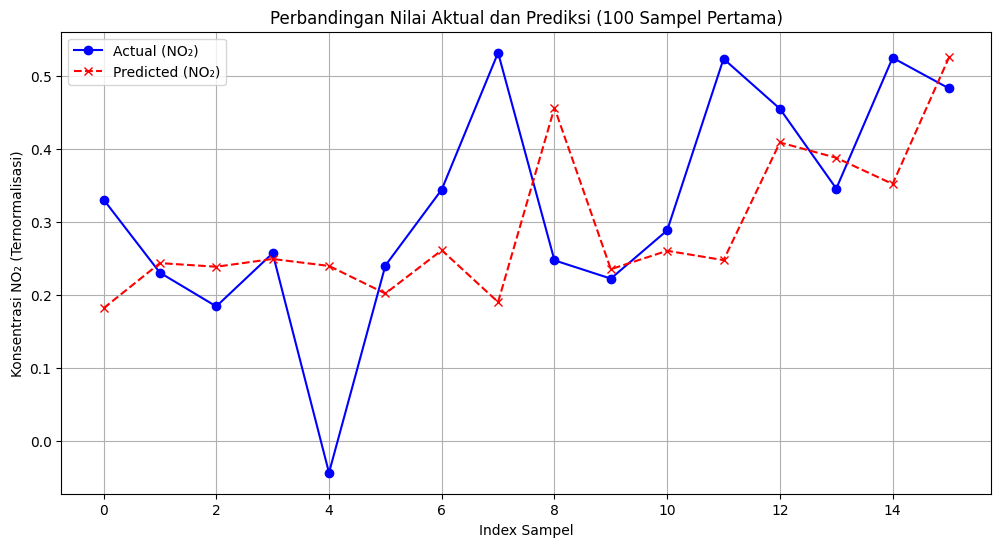

Model dan hasil prediksi berhasil disimpan:
   - model_knn_no2.pkl
   - hasil_prediksi_no2.csv
Proses training & evaluasi selesai tanpa error!


In [24]:
# =========================================================
# 1. IMPORT LIBRARY
# =========================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# =========================================================
# 2. BACA DATA NORMALISASI
# =========================================================
print("="*70)
print("MULAI TRAINING MODEL KNN REGRESSION")
print("="*70)

train_df = pd.read_csv("train_data_normalized.csv")
test_df = pd.read_csv("test_data_normalized.csv")

# Pastikan kolom NO2_norm ada
if "NO2_norm" not in train_df.columns:
    raise KeyError("Kolom 'NO2_norm' tidak ditemukan! Pastikan sudah melakukan normalisasi.")

# =========================================================
# 3. BUAT FITUR LAG (TIME SERIES SUPERVISED)
# =========================================================
def create_lag_features(df, col, n_lags=3):
    for lag in range(1, n_lags + 1):
        df[f"{col}_lag{lag}"] = df[col].shift(lag)
    return df.dropna()

train_df = create_lag_features(train_df, "NO2_norm", n_lags=3)
test_df = create_lag_features(test_df, "NO2_norm", n_lags=3)

# =========================================================
# 4. SIAPKAN DATA UNTUK MODEL
# =========================================================
fitur = ["NO2_norm_lag1", "NO2_norm_lag2", "NO2_norm_lag3"]

X_train = train_df[fitur].values
y_train = train_df["NO2_norm"].values
X_test = test_df[fitur].values
y_test = test_df["NO2_norm"].values

print(f"Fitur digunakan: {fitur}")
print(f"X_train shape : {X_train.shape}")
print(f"X_test shape  : {X_test.shape}")

# =========================================================
# 5. LATIH MODEL KNN
# =========================================================
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)
print("Model KNN berhasil dilatih!")

# =========================================================
# 6. PREDIKSI DAN EVALUASI
# =========================================================
y_pred = knn.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f"\n=== HASIL EVALUASI MODEL ===")
print(f"Mean Squared Error (MSE): {mse:.8f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape*100:.2f}%")

# =========================================================
# 7. VISUALISASI HASIL PREDIKSI
# =========================================================
plt.figure(figsize=(12, 6))
plt.plot(y_test[:100], label="Actual (NO₂)", color='blue', marker='o')
plt.plot(y_pred[:100], label="Predicted (NO₂)", color='red', linestyle='--', marker='x')
plt.title("Perbandingan Nilai Aktual dan Prediksi (100 Sampel Pertama)")
plt.xlabel("Index Sampel")
plt.ylabel("Konsentrasi NO₂ (Ternormalisasi)")
plt.legend()
plt.grid(True)
plt.show()

# =========================================================
# 8. SIMPAN MODEL DAN HASIL PREDIKSI
# =========================================================
joblib.dump(knn, "model_knn_no2.pkl")
pred_df = pd.DataFrame({
    "Actual_NO2_norm": y_test,
    "Predicted_NO2_norm": y_pred
})
pred_df.to_csv("hasil_prediksi_no2.csv", index=False)

print("Model dan hasil prediksi berhasil disimpan:")
print("   - model_knn_no2.pkl")
print("   - hasil_prediksi_no2.csv")

print("Proses training & evaluasi selesai tanpa error!")
